In [2]:
# default_exp segment

In [3]:
# !pip install -U numpy
# !pip install -U pil/pillow
# !pip install -U scipy

In [4]:
# !pip install wget
# !pip install torchmetrics
# !pip install hydra-core
# !pip install git+https://github.com/lucasb-eyer/pydensecrf.git
# !pip install omegaconf
# !pip install pytorch-lightning
# !git clone https://github.com/mhamilton723/STEGO.git
# !pip install seaborn


In [5]:
#export
import numpy as np
import os


import sys
sys.path.insert(0,'STEGO/src/')


from os.path import join
import wget
from train_segmentation import LitUnsupervisedSegmenter
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
from PIL import Image, ImageOps
import torchvision.transforms as T

import torch.nn.functional as F
from crf import dense_crf
import torch

/home/dima/DAB-DETR/STEGO/src/train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


In [6]:
#export

saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

In [ ]:
/home/dima/DAB-DETR/STEGO/checkpoints/cocostuff27/directory_exp1_date_Jul04_21-27-26/epoch=0-step=1200.ckpt

In [12]:
#own models
saved_model_name = "/home/dima/DAB-DETR/STEGO/checkpoints/cocostuff27/directory_exp1_date_Jul04_21-27-26/epoch=0-step=1200.ckpt"

In [13]:

  
model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_model_name)).cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/home/dima/anaconda3/envs/dab/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [14]:
#export
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [15]:
#export
def inference(img):
    transform = get_transform(448, False, "center")
    img = transform(img).unsqueeze(0).cuda()

    with torch.no_grad():
        code1 = model(img)
        code2 = model(img.flip(dims=[3]))
        code  = (code1 + code2.flip(dims=[3])) / 2
        code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
        linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()

        single_img = img[0].cpu()
        return dense_crf(single_img, linear_probs[0]).argmax(0)

In [16]:
#export
def exptrapolate(t,size):
    t = torch.Tensor(t).unsqueeze(0)
    t = torch.nn.functional.upsample(t,               (size)).squeeze(0)
    return torch.nn.functional.upsample(t.T.unsqueeze(0),(size)).squeeze(0)

In [30]:
#export
def get_food_segment(img,selectd_class = 2):

  img = crop_image_to_square(img)
  pred = inference(img)

  food_class = 2
  pred[pred!=food_class]=0
  pred[pred==food_class]=1
  mask = exptrapolate(pred,img.size[1])
  pred = inference(img)

  pred[pred!=selectd_class]=0
  pred[pred==selectd_class]=1
  mask = exptrapolate(pred,img.size[1])
  img = np.array(img) * np.stack([mask]*3).T
  return Image.fromarray(img.astype(np.uint8)),mask

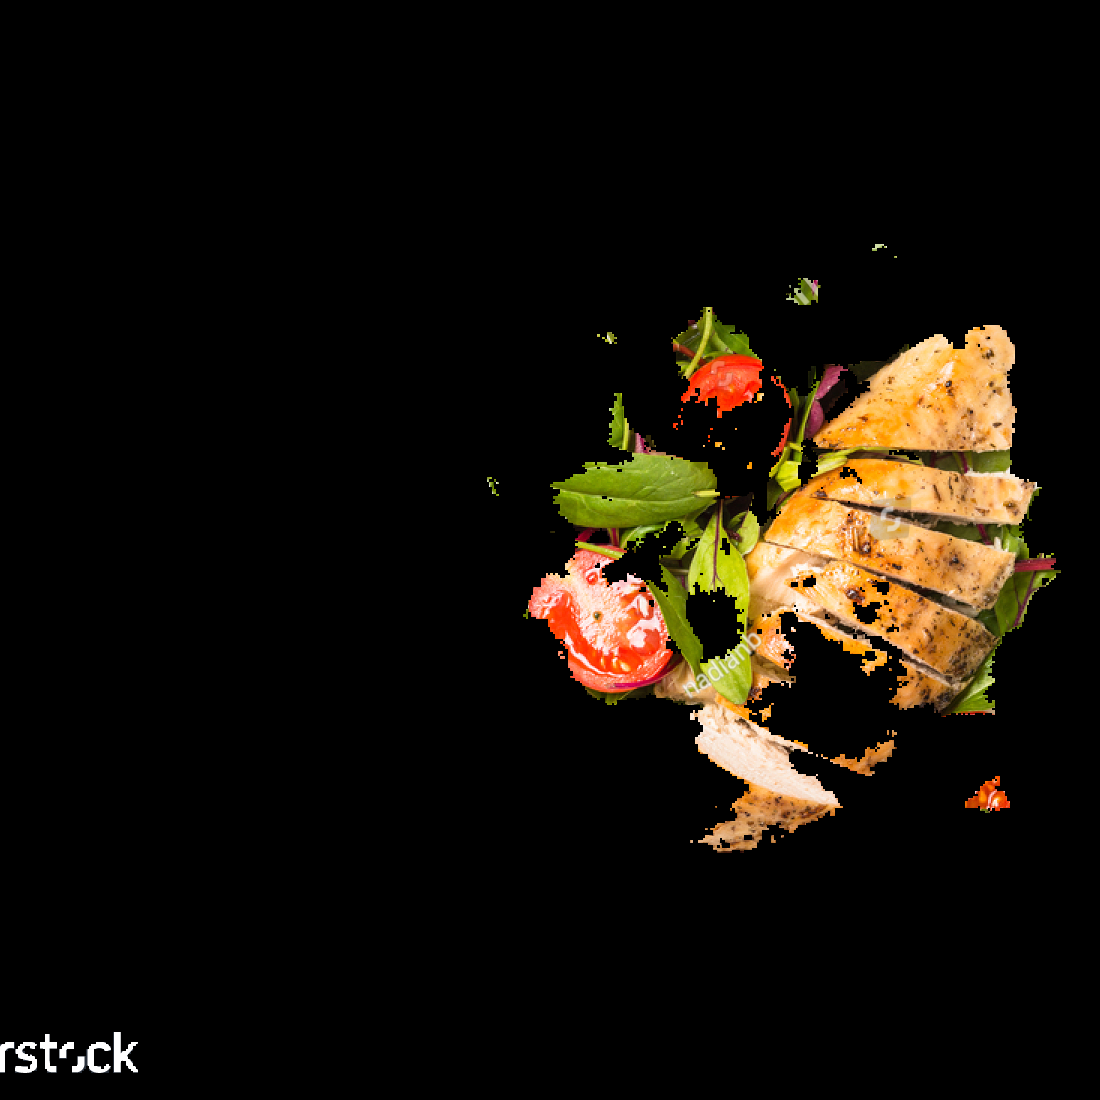

In [36]:
img_url ="https://image.shutterstock.com/z/stock-photo-chicken-fillet-with-salad-healthy-food-keto-diet-diet-lunch-concept-top-view-on-white-1721943142.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
get_food_segment(img,4)[0]

In [29]:
np.unique(mask)

array([0., 1., 2., 3., 4.], dtype=float32)

In [1]:
!nbdev_build_lib

Converted 00_paths.ipynb.
Converted 00_tools.ipynb.
Converted box_segment.ipynb.
Converted boxes.ipynb.
Converted food_segment.ipynb.
